In [6]:
import tensorflow as tf
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import backend as K

# --- ADDED: Definition for the custom layer ---
class simam_module(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(simam_module, self).__init__(**kwargs)
        self.activaton = tf.keras.activations.sigmoid
        self.e_lambda = 1e-4

    def call(self, x):
        _, h, w, c = x.shape
        n = w * h - 1
        d = (x - K.mean(x, axis=[1,2], keepdims=True)) ** 2
        v = K.sum(d, axis=[1,2], keepdims=True) / n
        e = d / (4 * (v + self.e_lambda)) + 0.5
        return x * self.activaton(e)

# --- Data Loader Functions (Corrected Indentation) ---
def load_and_process_mask_py(mask_path, size):
    mask_path = mask_path.numpy().decode('utf-8')
    mask = Image.open(mask_path)
    mask = mask.resize((size, size), Image.NEAREST)
    mask = np.array(mask)
    mask = np.where(mask > 6, 0, mask)
    return mask.astype(np.int32)

def parse_function(image_path, mask_path, size=256):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, [size, size])
    image = image / 255.0
    mask = tf.py_function(lambda p: load_and_process_mask_py(p, size), [mask_path], tf.int32)
    mask = tf.reshape(mask, [size, size, 1])
    return image, mask

def create_dataset(voc_root, txt_name, batch_size, size=256, is_train=False):
    txt_path = os.path.join(voc_root, "VOC2007", "ImageSets", "Segmentation", txt_name)
    with open(txt_path) as f:
        image_names = [line.strip() for line in f.readlines()]
    image_paths = [os.path.join(voc_root, "VOC2007", "JPEGImages", f"{name}.jpg") for name in image_names]
    mask_paths = [os.path.join(voc_root, "VOC2007", "SegmentationClass", f"{name}.png") for name in image_names]
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda img, msk: parse_function(img, msk, size), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [7]:
# --- Parameters ---
IMG_SIZE = 256
BATCH_SIZE = 4
NUM_CLASSES = 7

# --- Load Models ---
baseline_model = tf.keras.models.load_model('baseline_unet_model.h5')
print("--- Baseline U-Net Model Loaded ---")

# FIX: Tell Keras about our custom layer when loading
ma_model = tf.keras.models.load_model(
    'ma_unet_model.h5',
    custom_objects={'simam_module': simam_module}
)
print("--- MA-UNet Model Loaded ---")

# --- Load Validation Dataset ---
voc_root = '../VOCdevkit'
val_dataset = create_dataset(voc_root, 'val.txt', BATCH_SIZE, size=IMG_SIZE, is_train=False)
print("\n--- Validation Dataset Loaded ---")

--- Baseline U-Net Model Loaded ---



--- MA-UNet Model Loaded ---

--- Validation Dataset Loaded ---


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


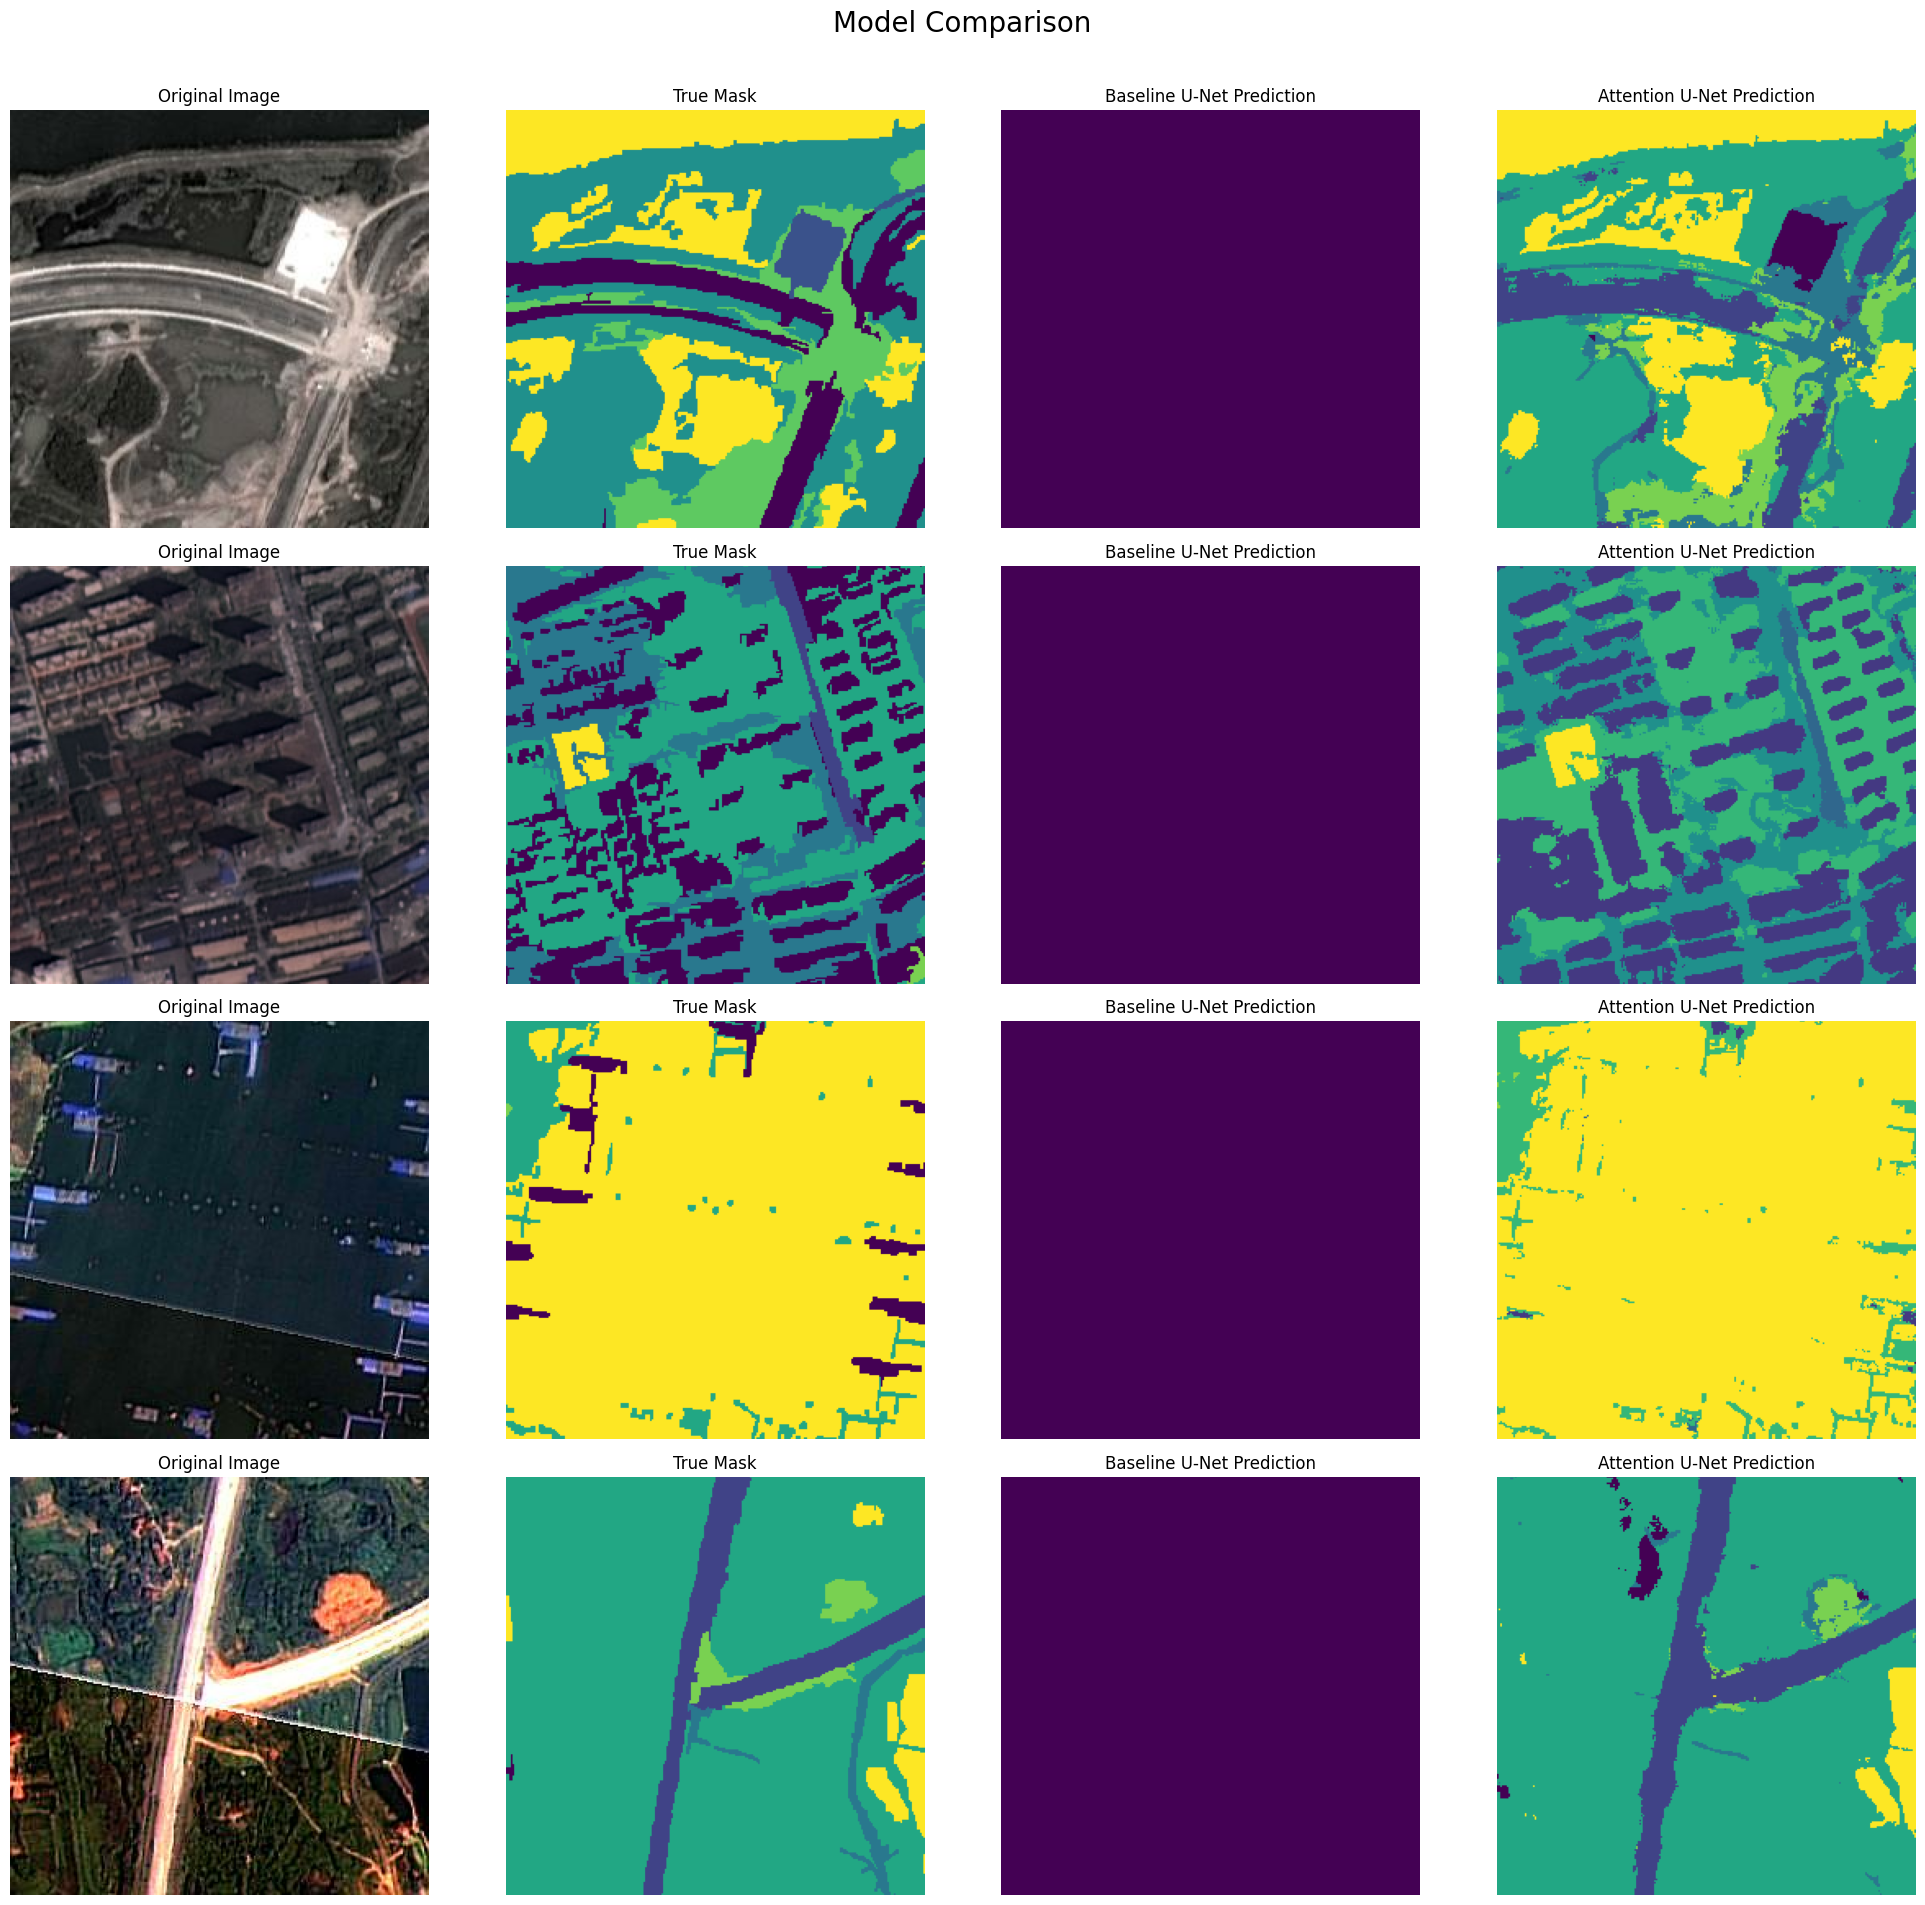

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step


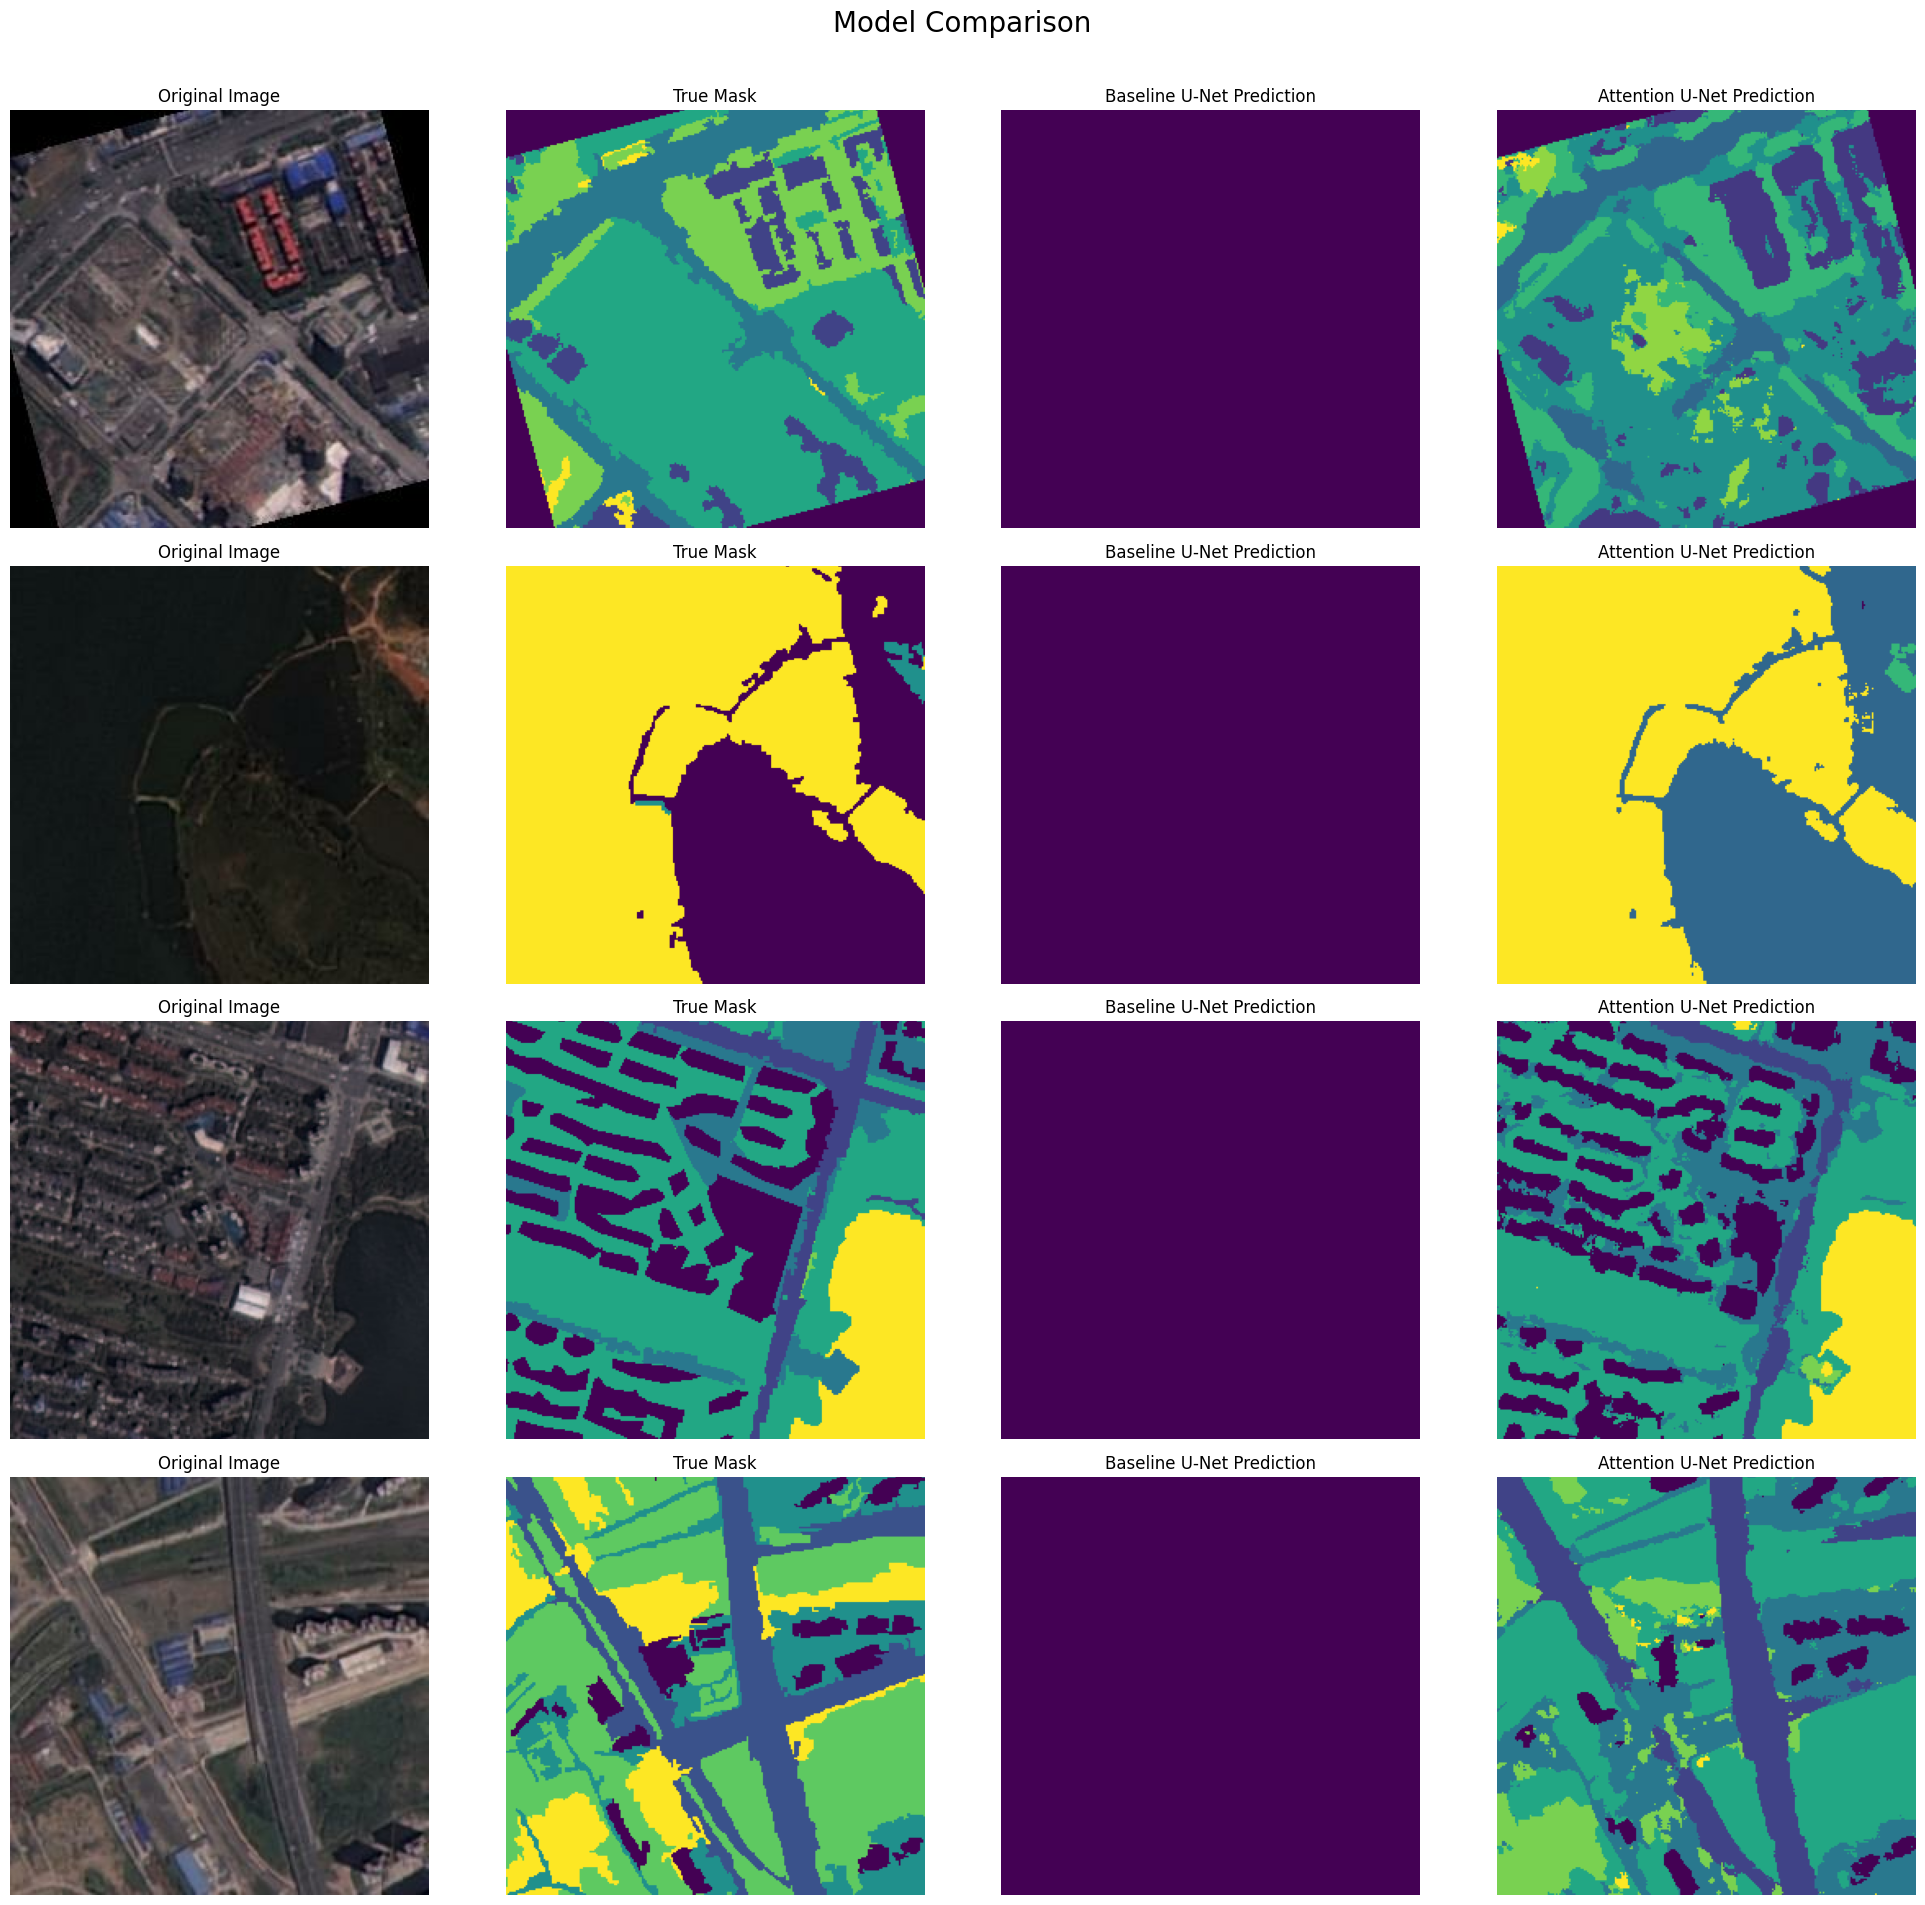

In [8]:
# --- Make Predictions and Visualize ---
for images, masks in val_dataset.take(2): # Take 2 batches to get more examples
    # Get predictions from both models
    baseline_preds = baseline_model.predict(images)
    ma_preds = ma_model.predict(images)
    
    # Convert predictions to class masks
    baseline_pred_masks = tf.argmax(baseline_preds, axis=-1)
    ma_pred_masks = tf.argmax(ma_preds, axis=-1)

    # --- Visualize the Results ---
    fig, axes = plt.subplots(BATCH_SIZE, 4, figsize=(20, 20))
    fig.suptitle("Model Comparison", fontsize=20)

    for i in range(BATCH_SIZE):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 1].imshow(tf.squeeze(masks[i]))
        axes[i, 1].set_title("True Mask")
        axes[i, 2].imshow(baseline_pred_masks[i])
        axes[i, 2].set_title("Baseline U-Net Prediction")
        axes[i, 3].imshow(ma_pred_masks[i])
        axes[i, 3].set_title("Attention U-Net Prediction")
        
        for ax in axes[i]: ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

In [9]:
# --- Quantitative Metrics ---
print("--- Calculating Metrics for Both Models ---")

# Initialize the metric we care about: Mean Intersection over Union
iou_metric = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)

# --- Evaluate Baseline Model ---
iou_metric.reset_state() # Reset metric before use
for images, masks in val_dataset:
    preds = baseline_model.predict(images)
    pred_masks = tf.argmax(preds, axis=-1)
    iou_metric.update_state(masks, pred_masks)
baseline_miou = iou_metric.result().numpy()
print(f"Baseline U-Net -> Mean IoU: {baseline_miou:.4f}")

# --- Evaluate Attention Model ---
iou_metric.reset_state() # Reset metric before use
for images, masks in val_dataset:
    preds = ma_model.predict(images)
    pred_masks = tf.argmax(preds, axis=-1)
    iou_metric.update_state(masks, pred_masks)
ma_miou = iou_metric.result().numpy()
print(f"Attention U-Net -> Mean IoU: {ma_miou:.4f}")

--- Calculating Metrics for Both Models ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━